**Tratamento de imagens astronômicas**

A forma mais natural de representar uma imagem no Python é usando um array do NumPy! Vamos ver uma aplicação disto no tratamento de imagens astronomicas. Na sessão sobre a demonstração veremos uma versão simplificada do processo de tratamento.

# Contexto


##  Como funciona uma câmera?!

As cameras funcionam à partir do efeito fotoelétrico! Ou seja, elas convertem energia luminosa em energia elétrica. Para isto ela dispõe de um arranjo quadricular de "elementos de pixel" que quando expostos à luz acumulam energia elétrica. 

![fonte: panasonic.com](ccd.png)


A energia acumulada no arranjo é lida por um circuito especial que mede a quantidade de energia em cada pixel e converte para escala numérica de intensidade, que é proporcional à quantidade de "raios luminosos" que chegam na região.

## O que é uma imagem?

As medidas das câmeras são guardadas como uma malha quadricular de intensidades que podem ser visualizadas como imagens. Para imagens coloridas teremos 3 valores, um para cada cor primária (R: Red, G: Green, B: Blue) e nas imagens em preto e branco, apenas 1 valor.

![fonte: towardsdatascience.com](image.png)

Ou seja, essa malha de pixels pode ser representada por uma matriz.

## O que tem de especial numa imagem astronômica?

Para imagens astronômicas (ou científicas no geral) existe uma preocupação maior com a precisão das medidas de energia luminosa. Por isso são usados formatos de imagem que preservam a precisão das medidas (No caso da astronomia o formato FITS) e onde podemos guardar os detalhes das circunstâncias de como as imagens foram tomadas, ou seja, a capacidade de adicionar metadados.

Em geral, imagens astronômicas são monocromáticas, medindo a energia luminosa em apenas uma faixa limitada do espectro visível (nesta demonstração iremos usar a banda V).

## Como é feito o tratamento de imagens astronômicas?

Devido à essa preocupação com a acurácia dos dados imagens astronômicas são tratadas para remover "vestígios" de energia elétrica gerados pela própria câmera e algumas distorções que parecem por conta do aparato ótico (telescópio, lentes, filtros, etc) de forma a deixar apenas a medida referente a energia dos raios luminosos.

Para isto devemos fazer:

- Correção do ruído de leitura (depende da câmera, neste exemplo ñ será feita)
- Combinação de imagens
- Correção de Bias (Ruido de base)
- Correção de Flat (Imperfeições)
 

# Demonstração

Vamos seguir o seguinte processo:

1. Serão geradas as imagens de calibração
2. Estas imagens são aplicadas às imagens astronômicas
3. As imagens astronômicas serão combinadas para conseguir a imagem final

## Carregando arquivos

Primeiramente vamos achar o nome dos nossos arquivos para poder carregá-los posteriormente, para isso usaremos um **glob**. Para esse tipo de tratamento são usadas imagens de calibração, ou seja, imagens "auxiliares" que nos ajudarão a deixar remover as imperfeições das imagens. Essas imagens são chamadas de:

- Bias (ou viés)
- Flat Field (ou campo uniforme)

Elas serão aplicadas nas imagens de ciência, ou seja, nas imagens que realmente queremos estudar.

Nossos arquivos estão na pasta "18out30.1". Nela temos as imagens brutas, ou seja, como saíram da câmera.

In [14]:
ls "18out30.1/"

bias_0018.fits  flat_0042.fits  OI2018B-011_2018-10-30_0136.fits
bias_0019.fits  flat_0043.fits  OI2018B-011_2018-10-30_0137.fits
bias_0020.fits  flat_0044.fits  OI2018B-011_2018-10-30_0138.fits


In [15]:
# Demo: Pegando o nome dos arquivos

from glob import glob

arquivos_bias = glob("18out30.1/bias*")
arquivos_flat = glob("18out30.1/flat*")
arquivos_ciencia = glob("18out30.1/OI*")

In [16]:
print(arquivos_flat)

['18out30.1/flat_0044.fits', '18out30.1/flat_0043.fits', '18out30.1/flat_0042.fits']


In [17]:
# Carregando uma imagem de bias

from astropy.io import fits
bias0 = fits.getdata(arquivos_bias[0]) # Matriz
hdr = fits.getheader(arquivos_bias[0]) # Cabeçalhos

In [37]:
bias0
#type(bias0)

array([[851, 854, 852, ..., 854, 854, 853],
       [856, 858, 850, ..., 853, 850, 856],
       [850, 855, 854, ..., 856, 855, 849],
       ...,
       [848, 856, 853, ..., 855, 851, 855],
       [855, 855, 853, ..., 853, 855, 854],
       [853, 852, 857, ..., 857, 851, 858]], dtype=uint16)

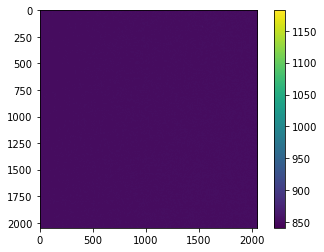

In [19]:
# Visualizando imagem

import matplotlib.pyplot as plt
plt.imshow(bias0)
plt.colorbar()

> O *bias* é uma imagem com o tempo mínimo de exposição. Ela é feita de modo que a eletrônica da câmera liga rapidamente e podemos ver o ruído de base gerado por ela. Por isso a imagem uniforme.

In [20]:
print(bias0.ndim)
print(bias0.shape)
print(bias0.size)
print(bias0.dtype)

2
(2048, 2048)
4194304
uint16


Das informações do array podemos ver que este array possui 2 dimensões, e está num arranjo de 2048x2048 pixels e está sendo representado por valores inteiros positivos (uint16).

> Dica: Para visualizar mais facilmente as imagens use o **sao ds9** um programa apropriado para a visualização rápida de imagens FITS.

## Criando os arquivos de calibração "master"

Primeiramente precisamos criar os arquivos de calibração master. Isso consiste em processar as imagens de calibração individuais de cada tipo em uma única imagem que possamos aplicar nas imagens de ciência.

Para fazer a combinação iremos "empilhar" as imagens em um cubo e tirar a mediana usando a dimensão da profundidade. Logo abaixo está um exemplo de um cubo de dados hiper-espectral de imageamento via satelite.

 ![fonte: esa,org](cube.jpeg)
 
 Montaremos algo semelhante. No entanto com imagens de bias ...

STD antes: 2.480043181084862 	 STD depois: 1.6753865245592372
Media final: 852.8319551944733


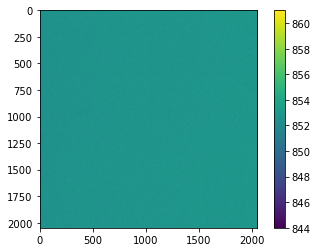

In [21]:
# Carregando imagens de bias

bias = [fits.getdata(arquivo) for arquivo in arquivos_bias]
hdr = fits.getheader(arquivos_bias[0])

# Empilhando imagens em um cubo de dados e combinando

bias_cube = np.stack(bias, axis=0)
master_bias = np.median(bias_cube, axis=0)

# Comparando ruído nas imagens

print(f"STD antes: {np.std(bias0)} \t STD depois: {np.std(master_bias)}")
print(f"Media final: {np.mean(master_bias)}")
plt.imshow(master_bias)
plt.colorbar()

In [38]:
bias_cube.shape
#bias_cube.ndim

(3, 2048, 2048)

Agora devemos fazer o mesmo processo para as imagens de flat. Abaixo temos uma função para ver o processo.

In [23]:
def combinar_imagens(lista_de_arquivos, nome_da_saida, escrever=False):
    """
    Dada uma lista de arquivos FITS, combina as imagens
    e escreve o resultado em disco (se escrever=True)
    
    Entrada:
        lista_de_arquivos: lista ou coleção de string
            Nomes dos arquivos para combinar
        nome_da_saida: string
            Nome para gravar arquivo
        escrever: bool
            Se verdadeiro escreve o resultado em disco. (padrão é falso)
            
    Transformações de arquivo:
        Grava novo arquivo FITS, com nome passado em nome_da_saida
         (se escrever=True)
        
    Retorno:
        imagem_final: array 2D do NumPy
            Imagem combinada
        hdr: astropy.io.fits.header.Header
            Cabeçalho da primeira imagem
    """
    # Carregando imagens
    imagens = [fits.getdata(arquivo) for arquivo in lista_de_arquivos]
    hdr = fits.getheader(lista_de_arquivos[0])
    imagem1 = imagens[0]
    
    # Fazendo combinação
    image_cube = np.stack(imagens, axis=0)
    final_image = np.median(image_cube, axis=0)
    
    print(f"sigma inicial:  {np.std(imagem1)} \t sigma final: {np.std(final_image)}")
    
    # Escrevendo resultado no disco
    if escrever:
        fits.writeto(nome_da_saida, final_image, hdr)
    
    return final_image, hdr

Vamos fazer o processo para cada imagem.

In [24]:
master_bias, _ = combinar_imagens(arquivos_bias, "master_bias.fits")
master_flat, _ = combinar_imagens(arquivos_flat, "master_flat.fits")

sigma inicial:  2.480043181084862 	 sigma final: 1.6753865245592372
sigma inicial:  529.7537561368949 	 sigma final: 527.1017496148625


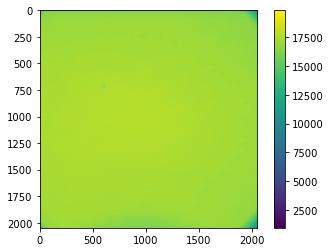

In [25]:
plt.imshow(master_flat)
plt.colorbar()

Agora precisamos remover o viés normalizar a imagem de flat pela mediana ... Lembre-se que ela será usada para uniformizar a imagem.

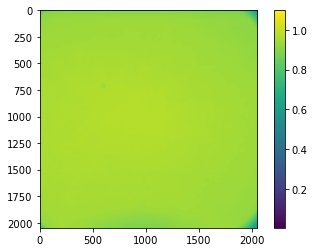

In [26]:
norm_master_flat = (master_flat - master_bias)/np.median(master_flat)
plt.imshow(norm_master_flat)
plt.colorbar()

>  Note como podemos expressar as operações em cada elemento de pixel naturalmente com o numpy.

## Aplicando imagens de calibração

Agora que temos as imagens master de calibração podemos aplicar nas imagens de ciência.

Nós queremos extrair das imagens o sinal relacionado com a energia luminosa dos corpos celestes. O processo é resumido pela seguinte fórmula:

$$ Sinal(x, y) = \frac{Valor Bruto - Viés}{Campo Normalizado}$$

Vamos carregar as imagens de ciência e fazer esta operação para cada uma.

In [27]:
ciencia = [fits.getdata(arquivo) for arquivo in arquivos_ciencia]

im = ciencia[0].copy()
hdr = fits.getheader(arquivos_ciencia[0])

processado = [(imagem - master_bias)/norm_master_flat for imagem in ciencia]

## Gerando imagem final

Vamos combinar as imagens processadas e ver o resultado final

In [28]:
cube = np.stack(processado, axis=0)
final = np.median(cube, axis=0)

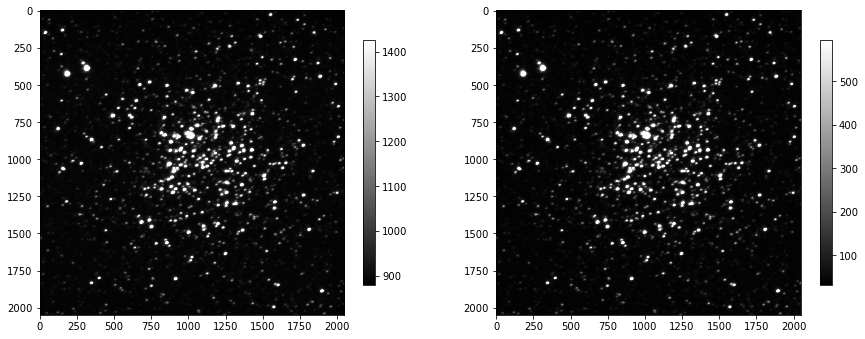

In [29]:
from matplotlib.colors import LogNorm

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(15, 15))

cax1 = ax1.imshow(im, vmin=np.quantile(im, .01), vmax=np.quantile(im, .99), cmap="gray")
fig.colorbar(cax1, ax=ax1, shrink=.3)
cax2 = ax2.imshow(final,vmin=np.quantile(final, .01), vmax=np.quantile(final, .99), cmap="gray")
fig.colorbar(cax2, ax=ax2, shrink=.3)

No que neste visualizador é difícil de perceber as mudanças estéticas na imagem. No entanto note que as barras de cor estão em escalas bem diferente. Para ver as diferenças mais de perto vale a pena abrir as imagens com um visualizador apropriado (ds9). 

In [30]:
# fits.writeto("final.fits", final, hdr)

## Medindo a largura de uma estrela e o brilho do céu

Uma tarefa corriqueira na área de astrofísica estelar é medir o tamanho angular das estrelas e o brilho do fundo do céu. Vamos reproduzir essa tarefa ... começando em como extrair uma estrela. Vamos ver uma janela de 30x30 pixel centrada na estrela que está sobre a linha 1946 e coluna 716 da nossa matriz.

> Curiosidade: Esta tarefa é muito comum para várias aplicações fora da astronomia, por exemplo, na microscopia, imageamento via satélite e para aplicações médicas.

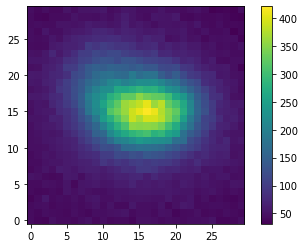

In [31]:
star = final[1946-15:1946+15, 716-15:716+15]
plt.imshow(star, origin="lower")
plt.colorbar()

> Cuidado! A indexação no numpy indexa primeiro as linhas e depois as colunas (Y, X) não as colunas e depois linhas como em outras linguagens (X, Y)

In [32]:
star.shape

(30, 30)

Existem várias formas de realizar estas medidas. Vamos usar uma forma rudimentar para ter uma estimativa.

Note que a estrela é mais alongada em uma direção que em outra, isto ocorre por defeitos da ótica, mecânica ou turbulência atmosférica. Portanto devemos levar em consideração a informação dos dois eixos. 

Primeiramente vamos visualizar a projeção das médias ao longo dos dois eixos.

Text(0.5, 1.0, 'Projeção no eixo X')

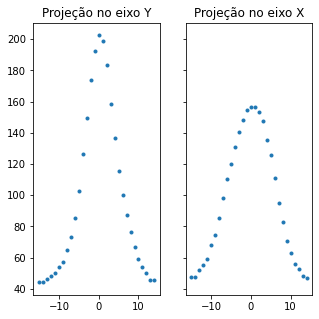

In [33]:
# Criando figura

fig, [ax1, ax2] = plt.subplots(ncols=2, sharey=True, figsize=(5, 5))

# Projeção das médias de energia luminosa nos eixos

X = np.mean(star, axis=0)
Y = np.mean(star, axis=1)

xx = np.arange(-15,15)
ax1.plot(xx, Y, marker=".", ls="none")
ax1.set_title("Projeção no eixo Y")
ax2.plot(xx, X, marker=".", ls="none")
ax2.set_title("Projeção no eixo X")

Note que as curvas se assemelham bastante com gaussianas. Logo vamos aproxima-las por gaussianas e usar a largura à meia altura (ou Full Width at Half Maximum - FWHM) da mesma como nossa estimativa de largura:

$$ f(x) = \frac{1}{\sigma \sqrt{2 \pi} } \exp \left[ -\frac{(x-\mu_0)^2}{2 \sigma^2} \right] + BKG$$

$$\mathrm{FWHM} =   2\sqrt{2 \ln 2 } \; \sigma \approx 2.355 \; \sigma$$

Para isso vamos ajustar uma gaussiana em cada eixo e a média dos dois valores que acharmos será a nossa estimativa "global" da estrela.

Para o ajuste usaremos a função curve_fit do scipy que o realiza via a minimização do chi quadrado.

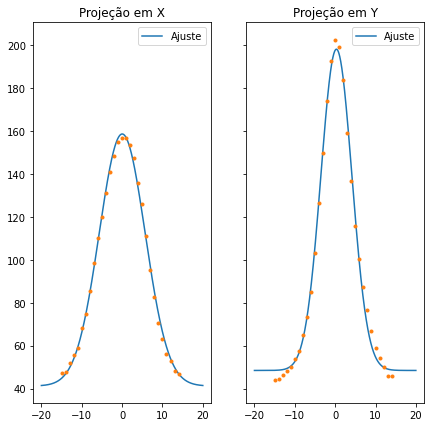

In [34]:
# Definindo modelo
from scipy.optimize import curve_fit

def gauss(x, *p):
    A, mu, sigma, bkg = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + bkg

def fwhm(μ):
    return 2.355*μ

# Loop em ambas as distribuições
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(7, 7))

resultados = []
for [dados, ax, titulo] in zip([X, Y], axes, ["Projeção em X", "Projeção em Y"]):
    # Chutes iniciais
    x = np.arange(-15, 15)
    A0 = max(dados)
    mu0 = 0
    sigma0 = 1
    bkg = np.min(dados)
    
    p0 = [A0, mu0, sigma0, bkg]
    
    # Realizando fit
    coeff, _ = curve_fit(gauss, x, dados, p0=p0)
    xx = np.linspace(-20, 20, 1000)
    ax.plot(xx, gauss(xx, *coeff), label='Ajuste')
    ax.plot(x, dados, marker=".", ls="none")
    ax.set_title(f"{titulo}")
    ax.legend()
    resultados.append(coeff)

resultados = np.array(resultados)

Neste caso, a base da gaussiana é a estimativa do brilho do fundo do céu e a largura pode ser determinada com a fórmula acima.

In [35]:
# Tirando a média dos coeficientes ajustados

medias = np.mean(resultados, axis=0)
medias

array([133.42309218,   0.16725366,   4.7683493 ,  44.79826399])

In [36]:
A, μ, σ, bkg = medias

print(f"Brilho do fundo do céu (ou Background): {bkg:.2f}")
print(f"Largura da estrela (FWHM): {fwhm(σ):.2f}")

Brilho do fundo do céu (ou Background): 44.80
Largura da estrela (FWHM): 11.23


Portanto temos um background de 44.8 contagens e a largura da estrela é de 11.23 pixels.

# Desafio

Crie uma função, que pode gerar uma estimativa global da largura à meia altura e background para a imagem usando várias estrelas em locais diferentes. Primeiramente selecione várias estrelas (umas 5) espalhadas na imagem (idealmente as mais isoladas). Pense numa forma de passar estas coordenadas para uma função (juntamente com a matriz da imagem) que calcula os parâmetros para cada estrela e retorna a mediana dos parâmetros.

> Dica: Não se esqueça de começar a escrever a função com a criação de uma **docstring** como na função combinar_imagens.